# Predicting HI mass fraction for potential targets

Now that we've built a classifer for whether or not an ALFALFA-like survey might detect a given galaxy based on its $gri$ imaging, we need to predict its HI mass fraction. We can choose one of the following trained models (or train a new one...):

- a.40 model
- xGASS model
- combined a.40 + xGASS model

For now, let's go with the final option: **the combined a.40 + xGASS model**

In [1]:
from fastai import *
from fastai.vision import *

from ranger import Ranger

PATH = Path('../..').resolve()

%matplotlib inline

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from morphomap import *


Mish activation loaded...
Mish activation loaded...


In [4]:
PATH

PosixPath('/home/jupyter/HI-diversity')

In [49]:
learn = custom_cnn_learner(bs=32, sz=224, legacy=False, cnn_model=mxresnet50)
# learn.load('combined-mxresnet50_80ep');

In [50]:
model = mxresnet50()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True).cuda()

learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-4,
    bn_wd=False,
    true_wd=True,
)

For some reason I can't recover my trained model???

In [51]:
learn.fit_fc(80, 1e-3, wd=1e-4)

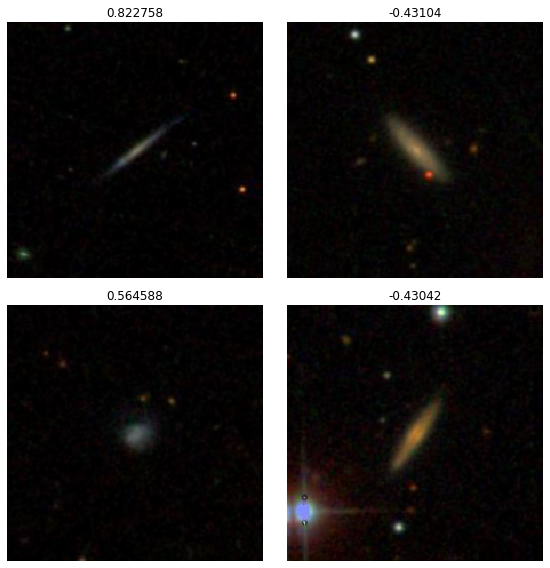

In [46]:
learn.data.show_batch(2)

In [56]:
# learn.save('combined-mxresnet50-fc_80ep');

In [52]:
preds, trues = learn.get_preds()

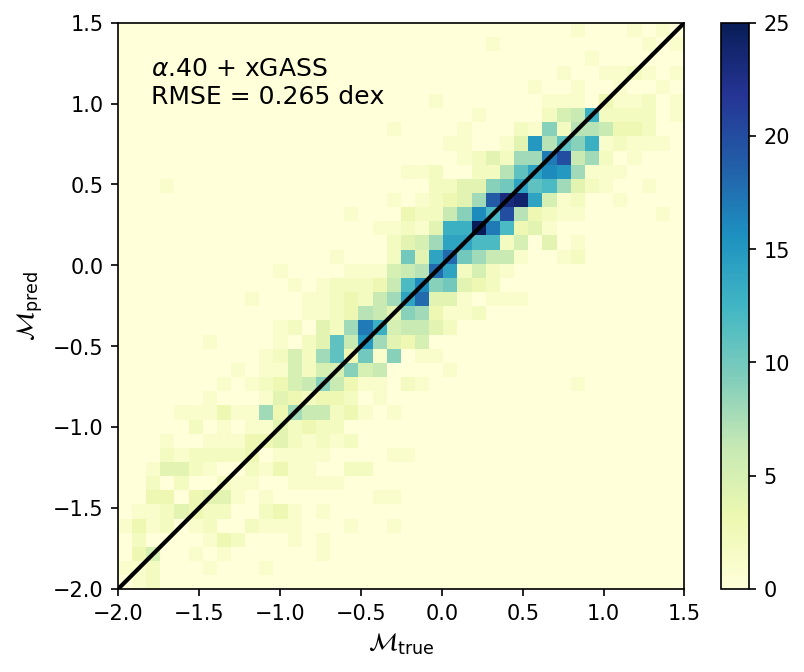

In [53]:
plt.figure(figsize=(6.2, 5), dpi=150)
plt.hist2d(flat_np(trues), flat_np(preds), cmap='YlGnBu', range=[(-2, 1.5), (-2, 1.5)], bins=40);
plt.plot([-2, 2], [-2, 2], c='black', ls='-', lw=2)

plt.gca().set_aspect('equal')
plt.colorbar();

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12);
plt.xticks(np.arange(-2, 2., .5))
plt.yticks(np.arange(-2, 2., .5));

rmse = root_mean_squared_error(trues, preds)
plt.text(-1.8, 1., r'$\alpha$.40 + xGASS' +'\n' + f'RMSE = {rmse:.3f} dex', fontsize=12);


## Load new data set

In [57]:
detect = pd.read_csv(f'{PATH}/results/nsa_notch-preds.csv')
detect.sample(2)

id          ra        dec         z          r  detected
834    nsa_97894  234.856932  21.525398  0.039248  16.308302         0
1270  nsa_125598  245.077656  20.036817  0.035872  16.660532         1

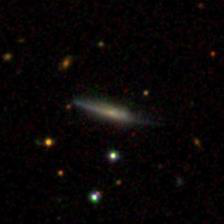

In [58]:
items = list(open_image(f'{PATH}/images-detectability/{o}.jpg') for o in detect.id)
items[256]

In [59]:
preds = np.stack([learn.predict(item)[0].data for item in items])

In [60]:
detect['logfgas_combined_pred'] = preds.flatten()

In [61]:
# detect.to_csv(f'{PATH}/results/nsa_notch-preds+HI.csv', index=False)

# Examine output

Text(0, 0.5, 'Number')

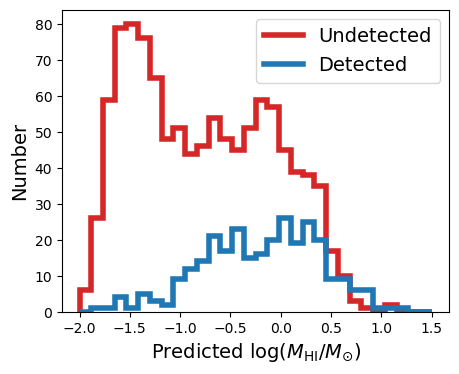

In [151]:
plt.figure(figsize=(5, 4), dpi=100)

detect[~detect.detected.astype(bool)].logfgas_combined_pred.hist(bins=30, range=[-2, 1.5], ax=plt.gca(), ls='-', lw=4, histtype='step', color='C3', label='Undetected')
detect[detect.detected.astype(bool)].logfgas_combined_pred.hist(bins=30, range=[-2, 1.5], ax=plt.gca(), ls='-', lw=4, histtype='step', label='Detected')

# change histogram legend line handles
handles, labels = plt.gca().get_legend_handles_labels()
new_handles = [plt.Line2D([], [], lw=4, c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels, fontsize=14)

plt.grid(False)

plt.xlabel(r'Predicted log($M_{\rm HI} / M_{\odot}$)', fontsize=14)
plt.ylabel('Number', fontsize=14)

## Sources that should be detected

In [68]:
detected = detect[detect.detected.astype(bool)].copy()

In [70]:
detected.sort_values(by='logfgas_combined_pred', ascending=False, inplace=True)

### Most gas-rich

Gas mass fraction: 1.240


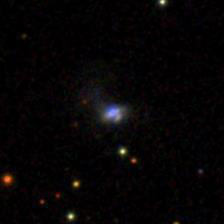

Gas mass fraction: 1.106


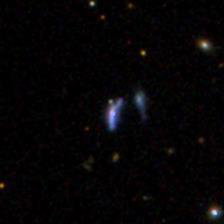

Gas mass fraction: 1.031


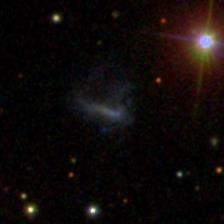

Gas mass fraction: 0.904


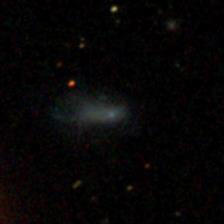

Gas mass fraction: 0.873


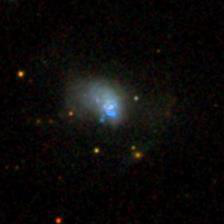

In [77]:
for _, row in list(detected.iterrows())[:5]:
    print(f'Gas mass fraction: {row.logfgas_combined_pred:.3f}')
    display(open_image(f'{PATH}/images-detectability/{row.id}.jpg'))

### Most gas-poor

Gas mass fraction: -1.779


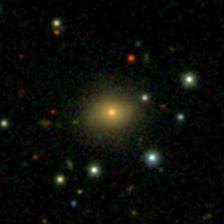

Gas mass fraction: -1.669


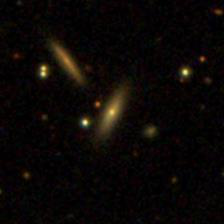

Gas mass fraction: -1.603


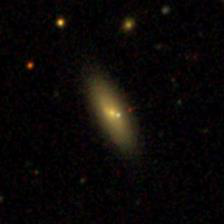

Gas mass fraction: -1.546


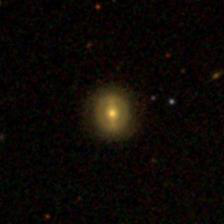

In [79]:
for _, row in list(detected.iterrows())[:-5:-1]:
    print(f'Gas mass fraction: {row.logfgas_combined_pred:.3f}')
    display(open_image(f'{PATH}/images-detectability/{row.id}.jpg'))

## Sources that shouldn't be detected (?)

In [80]:
undetected = detect[~detect.detected.astype(bool)].copy()
undetected.sort_values(by='logfgas_combined_pred', ascending=False, inplace=True)

Gas mass fraction: 1.113


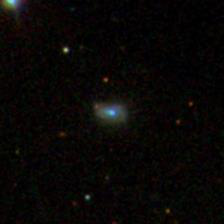

Gas mass fraction: 1.108


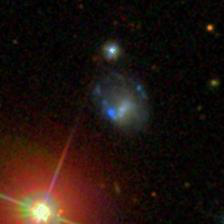

Gas mass fraction: 0.847


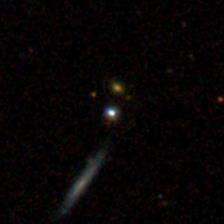

Gas mass fraction: 0.790


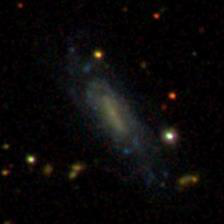

Gas mass fraction: 0.742


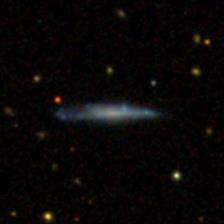

In [81]:
for _, row in list(undetected.iterrows())[:5]:
    print(f'Gas mass fraction: {row.logfgas_combined_pred:.3f}')
    display(open_image(f'{PATH}/images-detectability/{row.id}.jpg'))

Gas mass fraction: -1.964


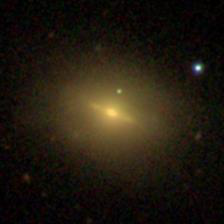

Gas mass fraction: -1.951


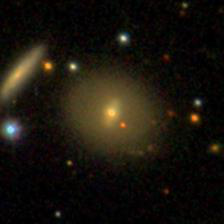

Gas mass fraction: -1.931


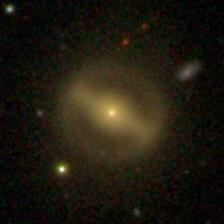

Gas mass fraction: -1.903


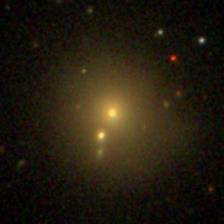

In [83]:
for _, row in list(undetected.iterrows())[:-5:-1]:
    print(f'Gas mass fraction: {row.logfgas_combined_pred:.3f}')
    display(open_image(f'{PATH}/images-detectability/{row.id}.jpg'))

# Select detected galaxies with logfgas = ± 0.5

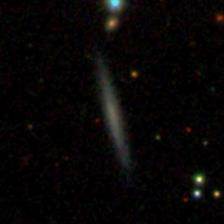

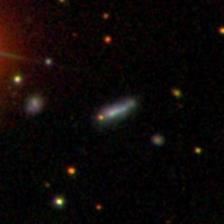

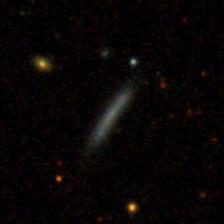

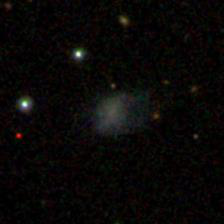

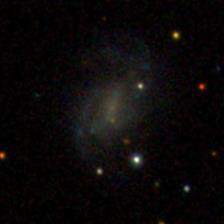

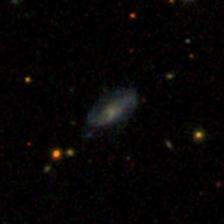

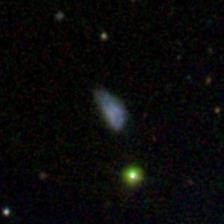

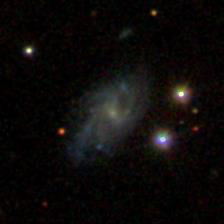

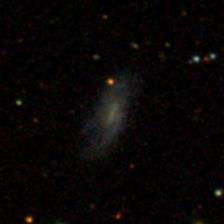

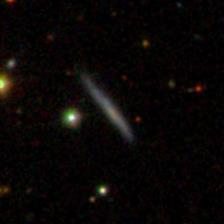

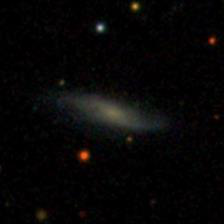

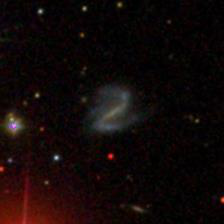

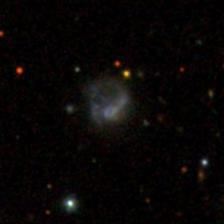

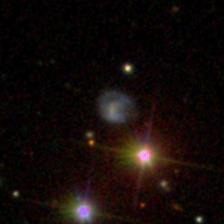

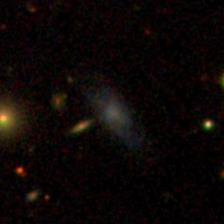

In [131]:
target = 0.5

for id_ in detected.id.iloc[np.argsort((detected.logfgas_combined_pred - target)**2)][:15]:
    display(open_image(f'{PATH}/images-detectability/{id_}.jpg'))

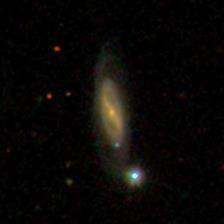

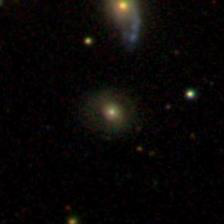

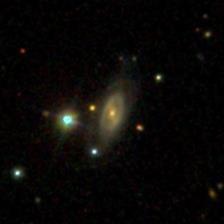

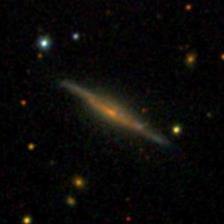

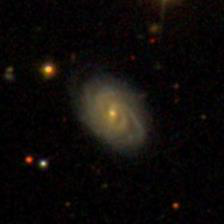

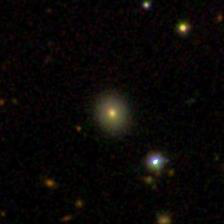

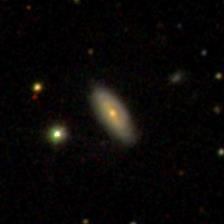

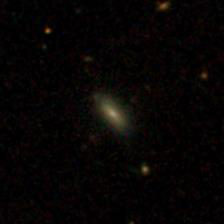

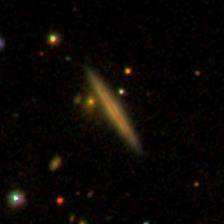

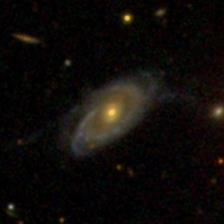

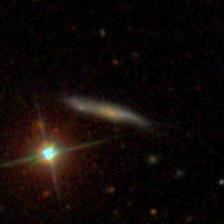

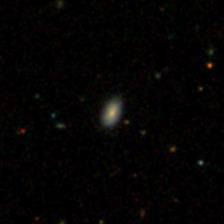

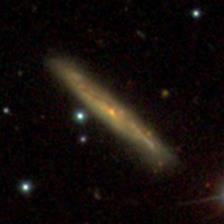

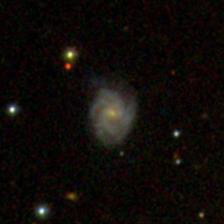

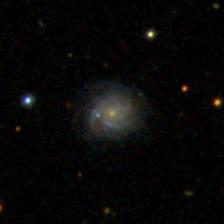

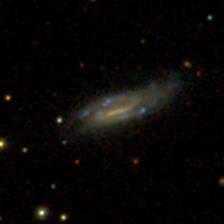

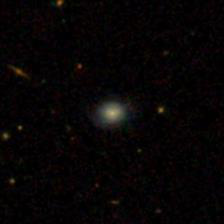

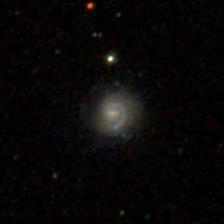

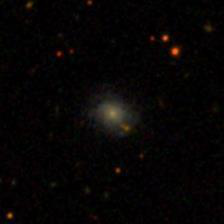

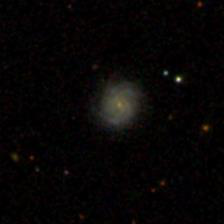

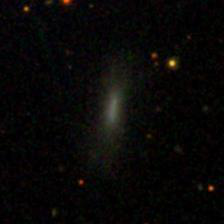

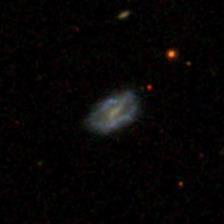

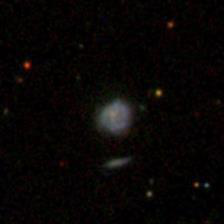

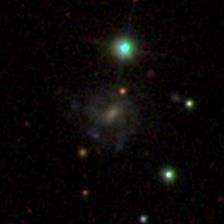

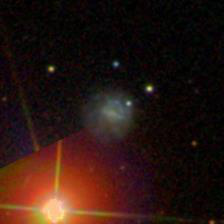

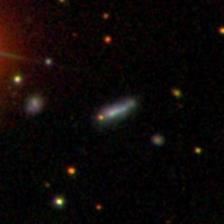

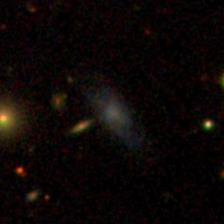

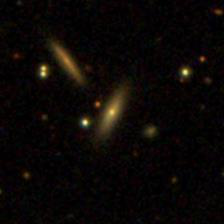

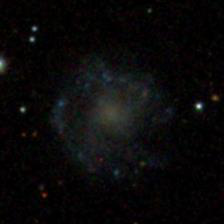

In [132]:
target = -0.5

for id_ in detected.id.iloc[np.argsort((detected.logfgas_combined_pred - target)**2)][::10]:
    display(open_image(f'{PATH}/images-detectability/{id_}.jpg'))